In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

PATH_TO_MASKS = 'postgres/20211004-074221_grab_cut_mask.csv'

NUMBER_OF_CELLS = {'Neuroblastoma_5': 18, 'Neuroblastoma_16': 16, 'Neuroblastoma_10': 16, 'Normal_2': 26, 'Normal_4': 15}

*RQ2*: How does providing manual constraints to the segmentation method affect the quality of the segmentation?

Quality metrics:

* IoU

In [2]:
conn = sqlite3.connect('grabcutstudy.db')
masks_df = pd.read_sql_query('''select * from masks''', conn)
conn.close()

In [3]:
def idx_str_to_np_array(x):
    indices = [int(s) for s in x.split(',')]
    mask_array = np.empty((384, 512), dtype=np.uint8).ravel()
    mask_array.fill(0)
    mask_array[indices] = 1
    return mask_array.reshape((384, 512))


masks_df['mask_arr'] = masks_df['mask'].apply(idx_str_to_np_array)
del masks_df['mask']

In [4]:
# 'image_id': ['neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4']

neurblas5_masks = masks_df.loc[masks_df['image_id'] == 'neurblas5', 'mask_arr'].values
neurblas10_masks = masks_df.loc[masks_df['image_id'] == 'neurblas10', 'mask_arr'].values
neurblas16_masks = masks_df.loc[masks_df['image_id'] == 'neurblas16', 'mask_arr'].values
normal2_masks = masks_df.loc[masks_df['image_id'] == 'normal2', 'mask_arr'].values
normal4_masks = masks_df.loc[masks_df['image_id'] == 'normal4', 'mask_arr'].values

In [5]:
neurblas5_masks = np.stack(neurblas5_masks, axis=0)
neurblas10_masks = np.stack(neurblas10_masks, axis=0)
neurblas16_masks = np.stack(neurblas16_masks, axis=0)
normal2_masks = np.stack(normal2_masks, axis=0)
normal4_masks = np.stack(normal4_masks, axis=0)

In [6]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

In [7]:
def compute_mean_iou_for_predictions(predictions, groundtruth):
    i = np.logical_and(predictions, groundtruth)
    u = np.logical_or(predictions, groundtruth)
    return np.sum(i) / np.sum(u)

In [8]:
neurblas5_iou = compute_mean_iou_for_predictions(neurblas5_masks, neurblas5_gt)
neurblas10_iou = compute_mean_iou_for_predictions(neurblas10_masks, neurblas10_gt)
neurblas16_iou = compute_mean_iou_for_predictions(neurblas16_masks, neurblas16_gt)
normal2_iou = compute_mean_iou_for_predictions(normal2_masks, normal2_gt)
normal4_iou = compute_mean_iou_for_predictions(normal4_masks, normal4_gt)

In [9]:
# print(f"IoU for\n"
#       f"neurblas5:\t {neurblas5_iou}\n"
#       f"neurblas10:\t {neurblas10_iou}\n"
#       f"neurblas16:\t {neurblas16_iou}\n"
#       f"normal2:\t {normal2_iou}\n"
#       f"normal4:\t {normal4_iou}"
#       )

In [10]:
overview = {
    'image_id' : ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'],
    'submitted_masks': [len(neurblas5_masks), len(neurblas10_masks), len(neurblas16_masks),len(normal2_masks), len(normal4_masks)],
    'mean_iou': [neurblas5_iou, neurblas10_iou, neurblas16_iou, normal2_iou, normal4_iou],
    'number_of_cells': [NUMBER_OF_CELLS['Neuroblastoma_5'], NUMBER_OF_CELLS['Neuroblastoma_10'], NUMBER_OF_CELLS['Neuroblastoma_16'], NUMBER_OF_CELLS['Normal_2'], NUMBER_OF_CELLS['Normal_4']],
}

overview_df = pd.DataFrame(data=overview)

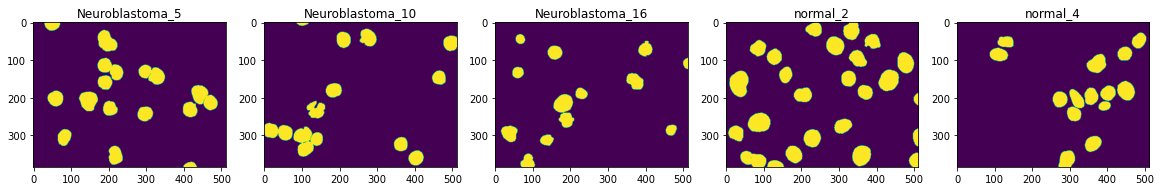

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

axs[0].set_title(f'Neuroblastoma_5')
axs[0].imshow(neurblas5_gt)

axs[1].set_title(f'Neuroblastoma_10')
axs[1].imshow(neurblas10_gt)

axs[2].set_title(f'Neuroblastoma_16')
axs[2].imshow(neurblas16_gt)

axs[3].set_title(f'normal_2')
axs[3].imshow(normal2_gt)

axs[4].set_title(f'normal_4')
axs[4].imshow(normal4_gt)

In [12]:
overview_df

,image_id,submitted_masks,mean_iou,number_of_cells
0,neurblas5,11,0.818907,18
1,neurblas10,10,0.836279,16
2,neurblas16,8,0.856618,16
3,normal2,12,0.815929,26
4,normal4,10,0.859991,15


In [13]:
#TODO boxplots for iou?
# plt.imshow(masks_df.loc[masks_df['id'] == '35175266-08d3-4fa9-b3eb-203d54b9f1bb', 'mask_arr'].values[0])